In [2]:
%matplotlib inline
from config_calc import *
import grid_tools

import cesm_orcas_sci as cesm
import cam
import gv

import colorbrewer

import pandas
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'
obs,mdl = gv.open_flightdata(case,mask=True)
mdl.info()

/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
earth_geometry.py:57: RuntimeWarning: invalid value encountered in less_equal
  mask = np.array((haversine(clon,clat,plon.ravel(),plat.ravel()) <= range_km))
gv.py:48: RuntimeWarning: invalid value encountered in less
  land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )
gv.py:51: RuntimeWarning: invalid value encountered in greater_equal
  region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )
gv.py:51: RuntimeWarning: invalid value encountered in less_equal
  region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )


xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		CO2_T09c:long_name = Takahashi

In [4]:
tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]

ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v],transformed='so_ocean_mean')

ds = cesm.convert_dataset(ds,case)
ds = ds.isel(zlev=np.where(ds.zlev < 15e3)[0])
ds.CO2_OCN.attrs['long_name'] = 'CESM'
ds

<xarray.Dataset>
Dimensions:     (time: 3347, zlev: 33)
Coordinates:
  * zlev        (zlev) float64 1.416e+04 1.315e+04 1.212e+04 1.107e+04 ...
  * time        (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Data variables:
    O2_OCN      (time, zlev) float64 8.963 8.99 9.111 9.818 11.27 13.62 ...
    CO2_CROF    (time, zlev) float64 4.6 4.807 5.156 5.605 5.989 6.223 6.297 ...
    CO2_LND     (time, zlev) float64 0.3145 0.3642 0.5007 0.6551 0.7804 ...
    CO2_T09     (time, zlev) float64 -0.7934 -0.8375 -0.9395 -1.106 -1.29 ...
    CO2_T09a    (time, zlev) float64 -0.7796 -0.823 -0.9232 -1.086 -1.265 ...
    CO2_T09b    (time, zlev) float64 -0.7665 -0.8095 -0.9094 -1.073 -1.254 ...
    CO2_T09c    (time, zlev) float64 -0.7865 -0.8302 -0.9314 -1.096 -1.277 ...
    CO2_T09d    (time, zlev) float64 -0.78 -0.8235 -0.9245 -1.089 -1.272 ...
    CO2_T09e    (time, zlev) float64 -0.8002 -0.8447 -0.9476 -1.116 -1.303 ...
    CO2_T09f    (time, zlev) float64 -0.8068 -0.8514 -0.9545 -

### O2-CO2 ratios

In [5]:
%%time
alt_bins = np.arange(0.,9.,1.)
lat_bins = np.arange(-75.,-30.,5.)
binlat = lambda ds: ds.groupby_bins('GGLAT',lat_bins).mean()

mdl_bin = mdl.groupby_bins('GGALT',alt_bins).apply(binlat)
obs_bin = obs.groupby_bins('GGALT',alt_bins).apply(binlat)

mdl_bin = mdl_bin.where(obs.N2O_QCLS>326)
obs_bin = obs_bin.where(obs.N2O_QCLS>326)
mdl_bin

CPU times: user 23.2 s, sys: 2.88 s, total: 26 s
Wall time: 24.3 s


In [6]:
lat_bins

array([-75., -70., -65., -60., -55., -50., -45., -40., -35.])

/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


[3847.08886719  -11.05006365]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 6.889e+06
Date:                Mon, 12 Feb 2018   Prob (F-statistic):               0.00
Time:                        12:45:43   Log-Likelihood:            -1.7442e+06
No. Observations:              731584   AIC:                         3.488e+06
Df Residuals:                  731582   BIC:                         3.488e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3847.0889 

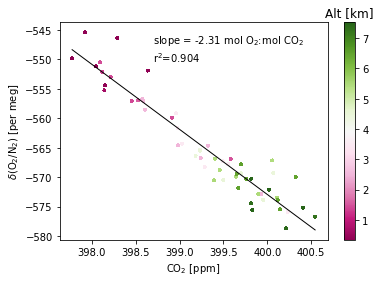

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = obs_bin.CO2_NOAA.values.ravel()
y = obs_bin.O2_AO2.values.ravel()
z = obs_bin.GGALT.values.ravel()
k = np.where(~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z))
x = x[k]
y = y[k]
z = z[k]

sc = ax.scatter(x,y,c=z,cmap='PiYG',s=4)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_ylabel('$\delta$(O$_2$/N$_2$) [per meg]')

cb = plt.colorbar(sc)
cb.ax.set_title('Alt [km]')

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())

s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k')

ax.text(398.7, -550., 'slope = {0:0.2f} mol O$_2$:mol CO$_2$\nr$^2$={1:0.3f}'.format(fitted.params[1]*0.2095,fitted.rsquared))
plt.savefig(os.path.join(diro['fig'],'o2-co2-obs.png'),dpi=300,bbox_inches='tight')

[7224.54307569  -17.96146783]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 9.805e+06
Date:                Mon, 12 Feb 2018   Prob (F-statistic):               0.00
Time:                        12:46:40   Log-Likelihood:            -1.9550e+06
No. Observations:              731584   AIC:                         3.910e+06
Df Residuals:                  731582   BIC:                         3.910e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7224.5431 

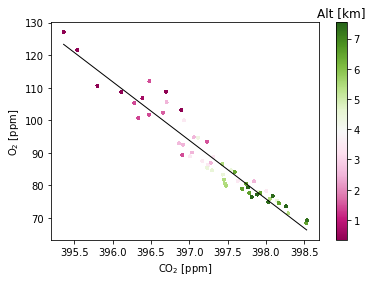

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = mdl_bin.CO2.values.ravel()
y = mdl_bin.O2_OCN.values.ravel()
z = mdl_bin.GGALT.values.ravel()
k = np.where(~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z))
x = x[k]
y = y[k]
z = z[k]

sc = ax.scatter(x,y,c=z,cmap='PiYG',s=4)

ax.set_xlabel('CO$_2$ [ppm]')
ax.set_ylabel('O$_2$ [ppm]')

cb = plt.colorbar(sc)
cb.ax.set_title('Alt [km]')

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())

s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k')

#ax.text(399., -550., 'slope = {:0.2f} mol O$_2$:mol CO$_2$'.format(fitted.params[1]))
